# Class: Parallel Programming
---
## TOPIC: <mark> SEAM CARVING </mark>

## Contributors:
- Tran Tuan Kiet (Group Leader)
- Le Thanh Loc
- Nguyen Duc Thang

# Table of contents

0. Introduction
1. Main idea
2. Convert from RGB to Grayscale
3. Convolution
4. Calculate the energy of each pixels using _gradient magnitude_
5. Find low energy seams
6. Remove low-energy seams
7. Demonstration with images
8. Preferences

# 0/ Introduction

__Seam carving__ (or __liquid rescaling__) is an algorithm for content-aware image resizing, developed by Shai Avidan, of Mitsubishi Electric Research Laboratories (MERL), and Ariel Shamir, of the Interdisciplinary Center and MERL. It functions by establishing a number of seams (paths of least importance) in an image and automatically removes seams to reduce image size or inserts seams to extend it. Seam carving also allows manually defining areas in which pixels may not be modified, and features the ability to remove whole objects from photographs.

The purpose of the algorithm is image retargeting, which is the problem of displaying images without distortion on media of various sizes (cell phones, projection screens) using document standards, like HTML, that already support dynamic changes in page layout and text but not images.

## Before

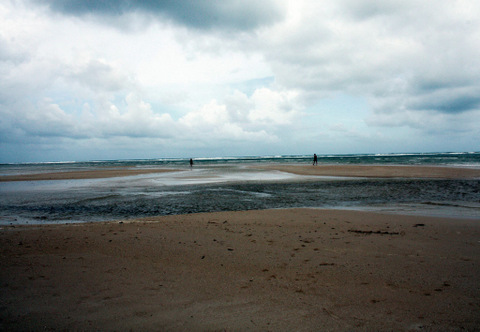

## After

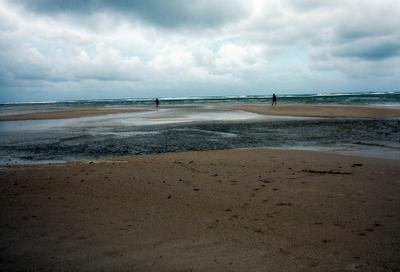

# 1/ Main idea

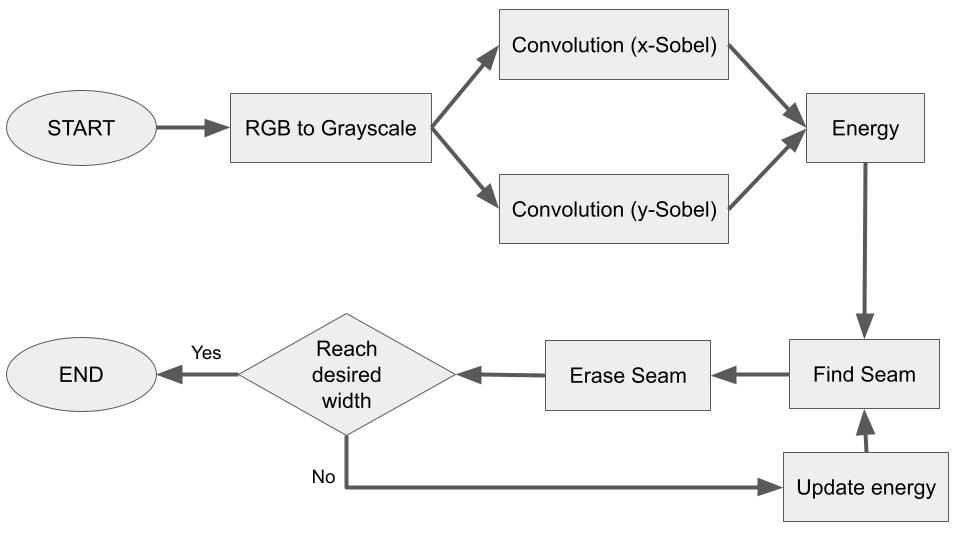

In this topic, we are not going to mark all seams at the time, then delete them all at once (like the image below) because of serveral reasons:
- In the process of removing a seam, it is possible to increase the importance of the adjacent seam.
- The seams marked at the same time can intersect.
- To ensure accuracy, need to remove seams one by one, each removed seam will be saved the coordinates (x, y) of each Pixel in that seam. Then compare the coordinates one by one with the original image, creating a red dot. From there we have the image below.

Comment:
- Pros: Easy to visualize, know which "dead space" has been removed.
- Cons: Doesn't contribute to better results, makes the algorithm more complicated.

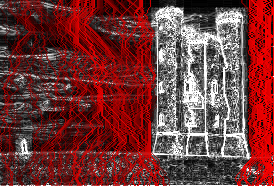

# 2/ Convert from RGB to Grayscale

- Formula: <mark>gray = 0.299 * red + 0.587 * green + 0.114 * blue</mark>
- Where each Pixel has been saved as _uchar3_ (struct: x, y, z)
- Reason:
  - To calculate the importance (energy) of each Pixels, working on 1 element is way easier than 3 elements.

## Device:
Each thread will handle each Pixel, read and write data from GMEM

# 3/ Convolution

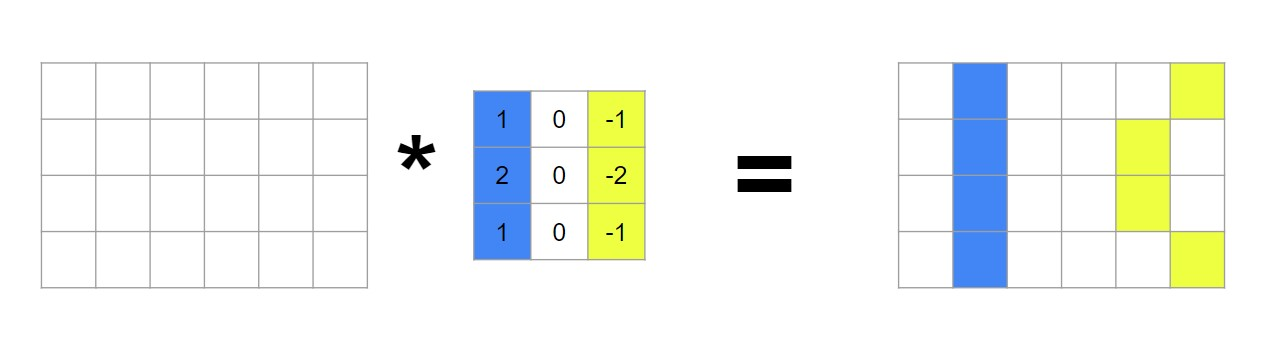

Convolution shows the importance of each Pixel, with the characteristics: __"The sum of all elements in a filter is 0."__

In the above example, _x-Sobel_ is used for vertical edge detection, when using a grayscale image (0 -> 255, dark -> light), if the left value is much larger than the right, the result of that Pixel is positive (highlighted in blue) and vice versa.

That is, the result will have value close to zero (non-edge), or the large value will be the edge, but these values are either positive or negative.

Although the edges might be positive or negative, this __not__ important. Since we can rotate this kernel 180&deg; to convert positive to negative or negative to positive. 

From there, we can use __absolute value__ (function _abs_) before adding with _y-Sobel_

## Example: Convolution between a grayscale picture with x-Sobel kernel

You can see the original image in __./images__

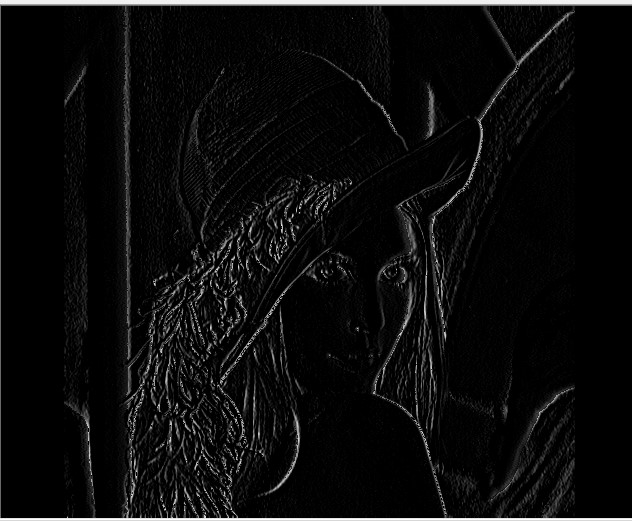

# 4/ Calculate the energy of each pixels using gradient magnitude

## Calculate from the bottom

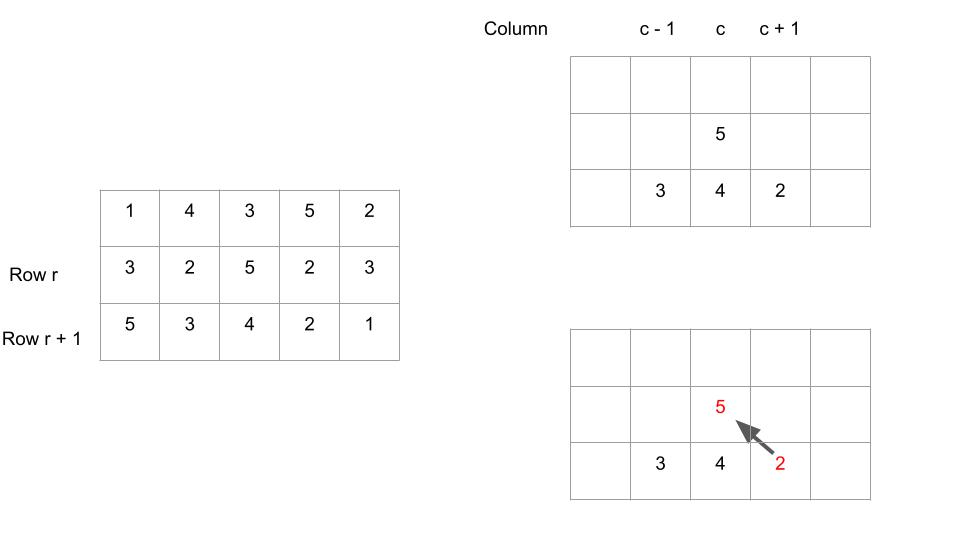

## Idea:
- Consider each line from the end up (except for the last line because of _"r + 1"_)
- The value of the cell is added from the smallest element in the 3 cells directly below
- If the cell under consideration is an edge, there are only 2 cells below it

## Note:
Before we begin the work of deleting a seam, we must recalculate this entire significance. Suppose, to delete 100 seam, all 100 degree tables will be created.

## Defect:
In the real-world application, when we want to drag and drop the application window to minimize the image, it will take a certain amount of time to produce the complete image, instead of dragging anywhere, the thumbnail image will go there.

## How to fix:
Update only Pixels located next to the deleted seam

## Calculation using device

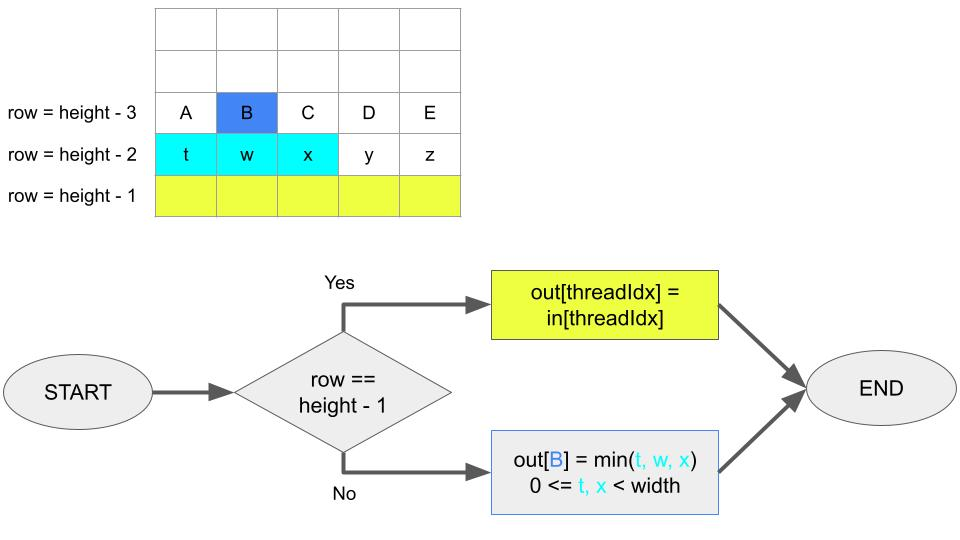

- We will combine the use of host and device to handle the above problem:
    - Host: Run the loop processing each line 1 time, starting from the bottom line.
    - Device: Put the global function in the above loop for processing.

- That is, each loop will successfully process 1 line, a new problem occurs: we cannot declare the number of threads with an entire image because we only process by line: 1 line for the last line (yellow line, image above), and 2 lines for the remaining lines (picture below).

- After the device completes, that is, the end of a loop, it will be the host's turn to execute the next line, which needs to be synchronized immediately.

- Jump of host's for loop: 1 line at a time.

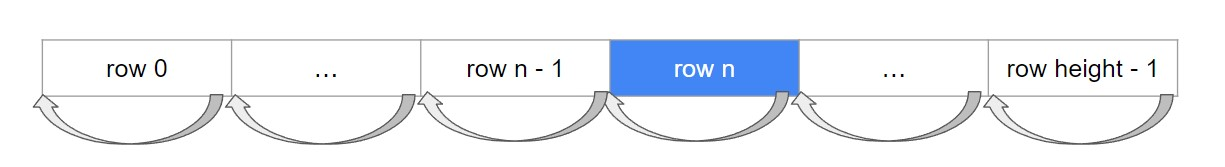

# 5/ Find low energy seams

The group have not yet coded the solution for device. Therefore, we are going to reuse host function.

Figure below: left is the significance to the bottom (minimal energy to the end) and right is the 1-dimensional array marked (in blue) the smallest seam.

- Go against the step of calculating the importance.
- The __i__ position in the right array is the i .th line

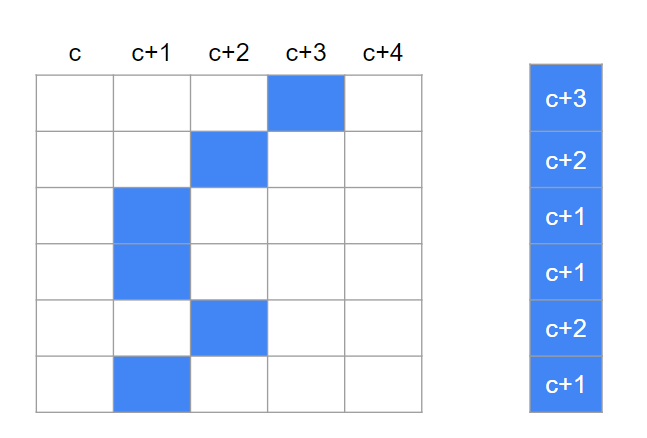

- First row: find the minimum value of the row
- Next row: get the column position of the "minimum value of the first row" (c+3)
     - Take 3 values of: (c+3)-1; (c+3); (c+3)+1; take the smallest value as (c+3)-1 = c+2. Save to the array on the right.
     - Keep going until reaching the last row.

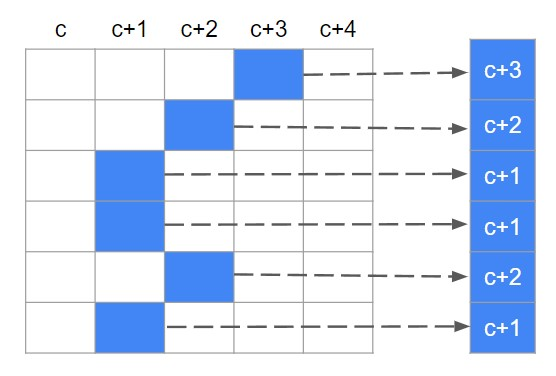

# 6/ Remove low-energy seams

## Host:
Output will add each element from the RGB, if this element is marked then skip it. Just like that, go to the end of the array.

We will demonstrate right on the 2-dimensional array of energy  to the end. (actually we will run on the RGB image)

### Psedocode: 
```cpp
for (int i = 0; i < width * heigth; i++) 
{
    if is_marked( input[i] ):
        continue;
    out.add( input[i] )
}
```

## Device: 
- For each row, for example the r<sup>th</sup> row (e.g. r=1), the elements before the blue cell will shift to the left r (r=1) units, the blue cell is not processed, the following cells are blue will shift right r + 1 (r+1 = 1+1 = 2) units.

### General: 
__r__<sup>th</sup> line: the elements before the cell are deleted, move left __r__ units; deleted cells are not considered; the cell after the deleted cell moves to the left __r+1__ units



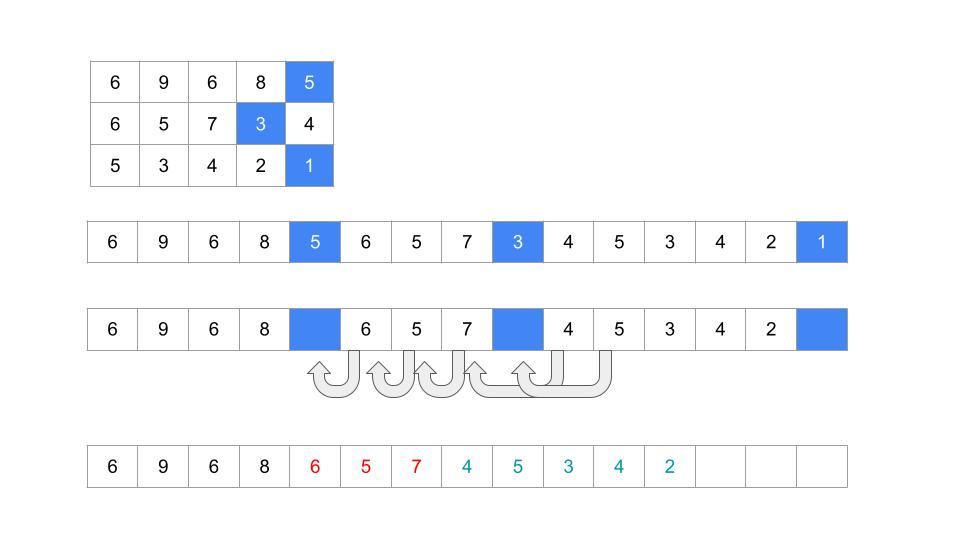

# 7/ Demo

In [ ]:
!git clone https://github.com/the0nlyWyvern/seam-carving.git
%cd ./seam-carving

Cloning into 'seam-carving'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 188 (delta 77), reused 160 (delta 49), pack-reused 0
Receiving objects: 100% (188/188), 8.69 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/seam-carving


## Read .pnm files and matrix

In [ ]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
    with open(file_name, 'r') as f:
        vals = f.read().split()
        w = int(vals[1])
        h = int(vals[2])
        if vals[0] == 'P2': # Grayscale
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
        elif vals[0] == 'P3': # RGB
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
        else:
            return None

    return Image.fromarray(pixels)

def show_matrix(matrix_file):
    '''
    input: filename
    output: show matrix

    Each element on the same line is sperated by a space
    '''
    m = np.loadtxt(matrix_file)
    m = m + m.min()
    m = m / m.max()
    m = m * 255
    m = m.astype(np.uint8)
    return Image.fromarray(m)

## Compile

In [ ]:
!nvcc -rdc=true ./main.cu ./src/*/* -o ./result/exe/seamCarving

## Args:
- The excution file will appear in __./result/exe__
- <mark>arg[0]</mark> ./result/exe/seamCarving
- <mark>arg[1]</mark> an input file (see ./images)
- <mark>arg[2]</mark> name of the output file with no extension (there will be 2 file _host and _device in ../result/)
- <mark>arg[3]</mark> new width 
- <mark>arg[1]</mark> blocksize.x
- <mark>arg[1]</mark> blocksize.y

## 7.1 Broadcast tower image

In [ ]:
!./result/exe/seamCarving ./images/broadcast_tower.pnm ./result/broadcast_tower 150

Image size (width x height): 274 x 186

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 92.947266 ms

Processing time of device: 48.040768 ms

Error between device result and host result: : 0.000000


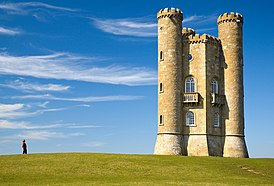

In [ ]:
show_pnm('./images/broadcast_tower.pnm')

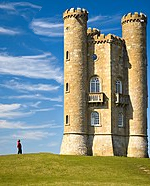

In [ ]:
show_pnm('./result/broadcast_tower_device.pnm')

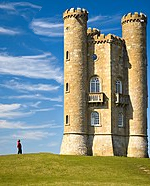

In [ ]:
show_pnm('./result/broadcast_tower_host.pnm')

## 7.2 Clock image

In [ ]:
!./result/exe/seamCarving ./images/clock.pnm ./result/clock 312

Image size (width x height): 788 x 599

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 2718.868408 ms

Processing time of device: 618.871948 ms

Error between device result and host result: : 2.018685


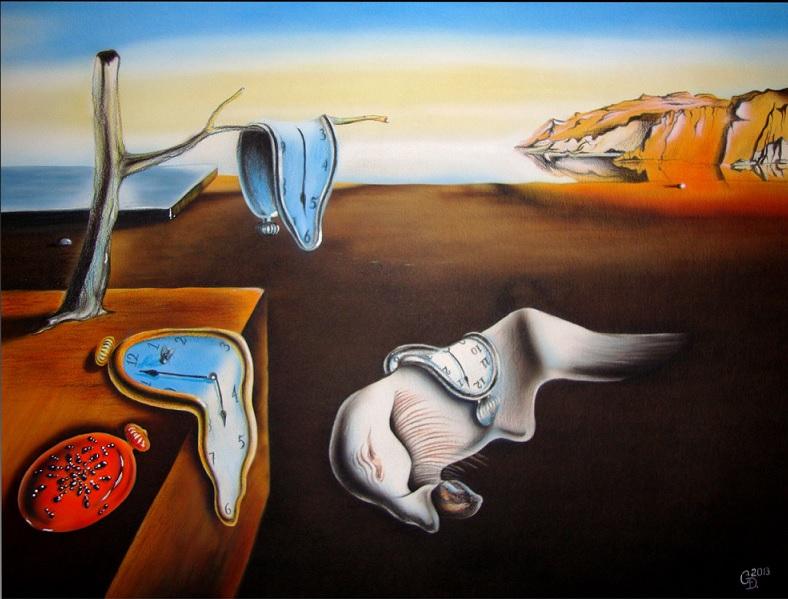

In [ ]:
show_pnm('./images/clock.pnm')

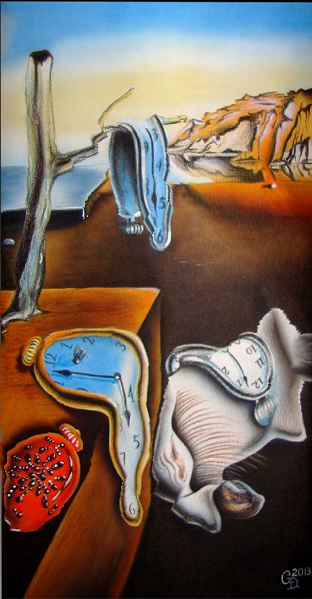

In [ ]:
show_pnm('./result/clock_host.pnm')

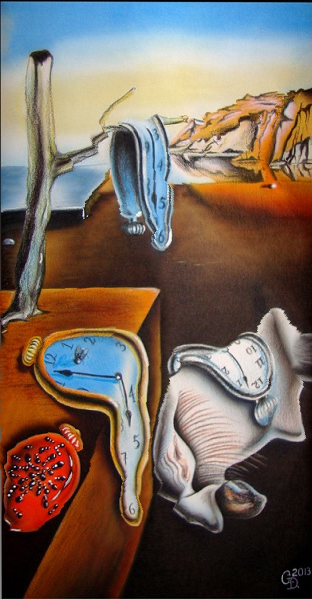

In [ ]:
show_pnm('./result/clock_device.pnm')

## 7.3 Cat image

In [ ]:
!./result/exe/seamCarving ./images/cat.pnm ./result/cat 150

Image size (width x height): 240 x 320

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 102.759232 ms

Processing time of device: 30.866816 ms

Error between device result and host result: : 0.000000


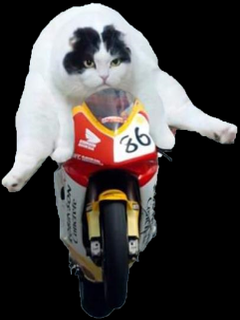

In [ ]:
show_pnm('./images/cat.pnm')

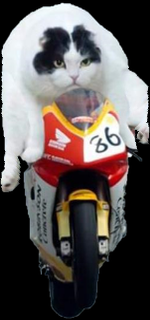

In [ ]:
show_pnm('./result/cat_host.pnm')

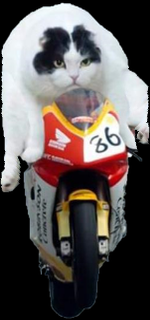

In [ ]:
show_pnm('./result/cat_device.pnm')

## 7.4 Elephant image

In [ ]:
!./result/exe/seamCarving ./images/elephant.pnm ./result/elephant 300

Image size (width x height): 787 x 444

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 1555.441406 ms

Processing time of device: 532.458923 ms

Error between device result and host result: : 0.000000


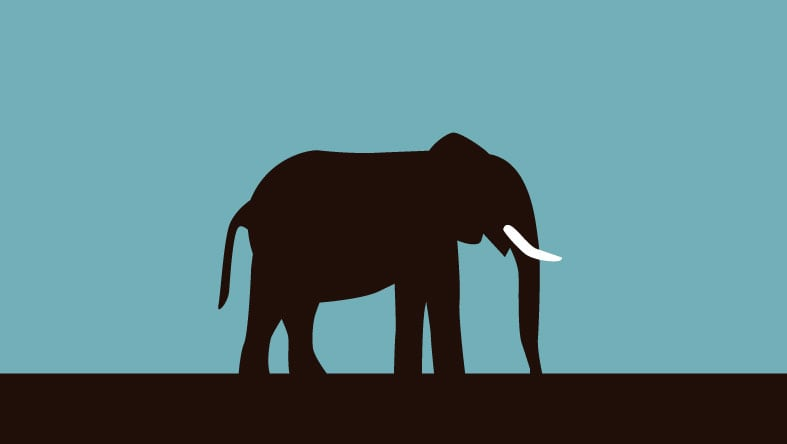

In [ ]:
show_pnm('./images/elephant.pnm')

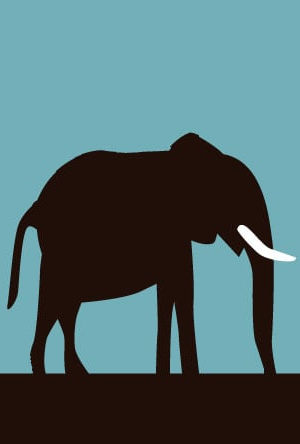

In [ ]:
show_pnm('./result/elephant_host.pnm')

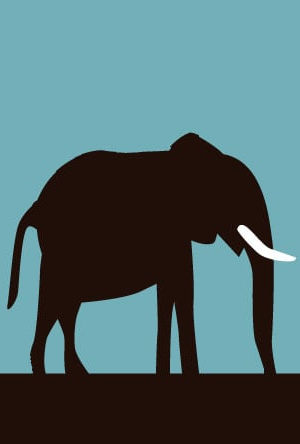

In [ ]:
show_pnm('./result/elephant_device.pnm')

## 7.5 Snail image

In [ ]:
!./result/exe/seamCarving ./images/snail.pnm ./result/snail 150

Image size (width x height): 256 x 256

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 96.548195 ms

Processing time of device: 31.046400 ms

Error between device result and host result: : 0.000000


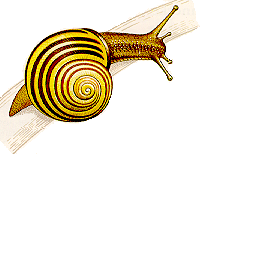

In [ ]:
show_pnm('./images/snail.pnm')

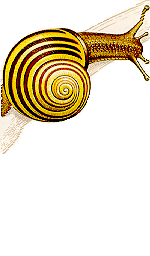

In [ ]:
show_pnm('./result/snail_host.pnm')

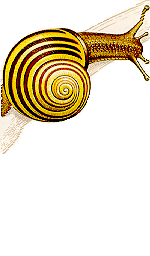

In [ ]:
show_pnm('./result/snail_device.pnm')

## 7.6 Lady image

In [ ]:
!./result/exe/seamCarving ./images/lady.pnm ./result/lady 300

Image size (width x height): 512 x 512

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15843721216 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 800.694580 ms

Processing time of device: 248.252991 ms

Error between device result and host result: : 0.873720


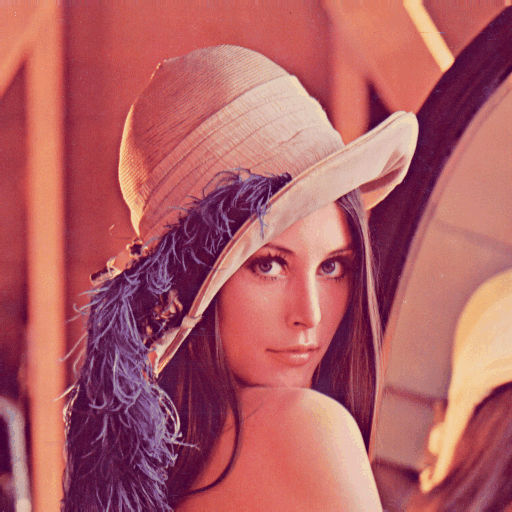

In [ ]:
show_pnm('./images/lady.pnm')

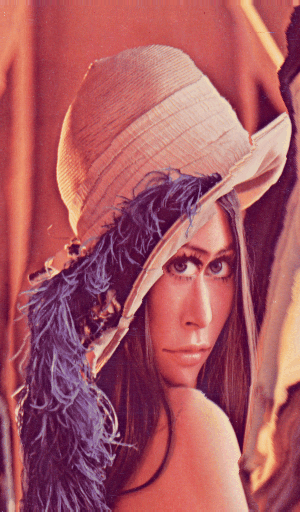

In [ ]:
show_pnm('./result/lady_host.pnm')

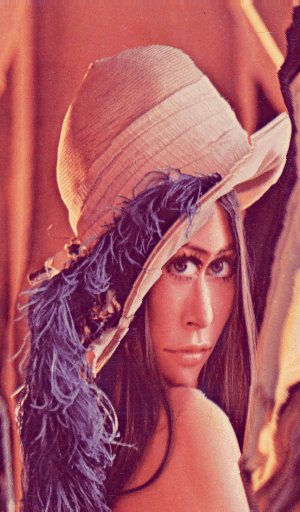

In [ ]:
show_pnm('./result/lady_device.pnm')

# 8/ References

[Slides from teacher Phạm Trọng Nghĩa]("https://drive.google.com/drive/folders/19_KM-2h6aa5OE8wDsM6kk5THcPHfKLjS" "Drive")

[Wikipedia - Seam Carving]("https://en.wikipedia.org/wiki/Seam_carving" "wikipedia")

[18.S191 MIT Fall 2020 - Seam Carving - Grant Sanderson]("https://www.youtube.com/watch?v=rpB6zQNsbQU" "youtube")

[MIT 18.S191 Fall 2020 - Seam Carving - James Schloss]("https://www.youtube.com/watch?v=ALcohd1q3dk" "youtube")

[Convolution - 3Blue1Brown - Grant Sanderson]("https://www.youtube.com/watch?v=KuXjwB4LzSA" "youtube")